In [1]:
import DSGRN
import DSGRN_utils
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from multiprocessing import Pool
import os
import json

In [2]:
from dsgrn_boolean.utils.hill_analysis import analyze_hill_coefficients
from dsgrn_boolean.utils.newton import newton_method
from dsgrn_boolean.utils.dsgrn_sample_to_matrix import extract_parameter_matrices
from dsgrn_boolean.utils.nullclines import plot_nullclines
from dsgrn_boolean.utils.interactive import plot_nullclines_interactive

from dsgrn_boolean.models.hill import HillFunction, hill

from dsgrn_boolean.utils.sample_management import load_samples

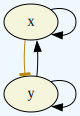

Number of parameter nodes: 196


In [3]:
net_spec = """x : x + y : E
              y : (~x) y : E"""

network = DSGRN.Network(net_spec)

G = DSGRN.DrawGraph(network)
display(G)

parameter_graph = DSGRN.ParameterGraph(network)

print('Number of parameter nodes:', parameter_graph.size())


In [4]:
par_list = [0, 49, 98, 147]

In [5]:
par_index = 98

parameter = parameter_graph.parameter(par_index)

# sampler = DSGRN.ParameterSampler(network)
n_samples = 10000
samples = load_samples(par_index)

# morse_graph, stg, graded_complex = DSGRN_utils.ConleyMorseGraph(parameter)
# DSGRN_utils.PlotMorseSets(morse_graph, stg, graded_complex)

Loaded 10000 samples for parameter node 98


In [6]:
# par_sample = sampler.sample(parameter)
# L, U, T = extract_parameter_matrices(par_sample, network)
# d = 100
# plot_nullclines_interactive(L, U, T, d)

In [7]:
# Expected number of equilibria
expected_eq = len(DSGRN.EquilibriumCells(parameter))
print("expected_equilibria = ", expected_eq)

expected_equilibria =  5


In [8]:
d_range = range(1,201)

Processing 100 samples for 1 d values using 15 processes
Estimated runtime: 11.0 seconds (0.2 minutes)
Pre-computing parameter matrices...


Testing Hill coefficients: 100%|██████████| 1/1 [00:10<00:00, 10.31s/it]

d=200: 90.0% match (90/100 samples)
  Matched samples: [0, 1, 2, 3, 4, 5, 6, 7, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 29, 30, 31, 32, 33, 34, 36, 37, 38, 39, 41, 42, 43, 44, 45, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 79, 80, 81, 82, 84, 85, 87, 88, 89, 91, 92, 93, 94, 95, 96, 97, 98, 99]
  Failed samples: [8, 9, 28, 35, 40, 46, 78, 83, 86, 90]


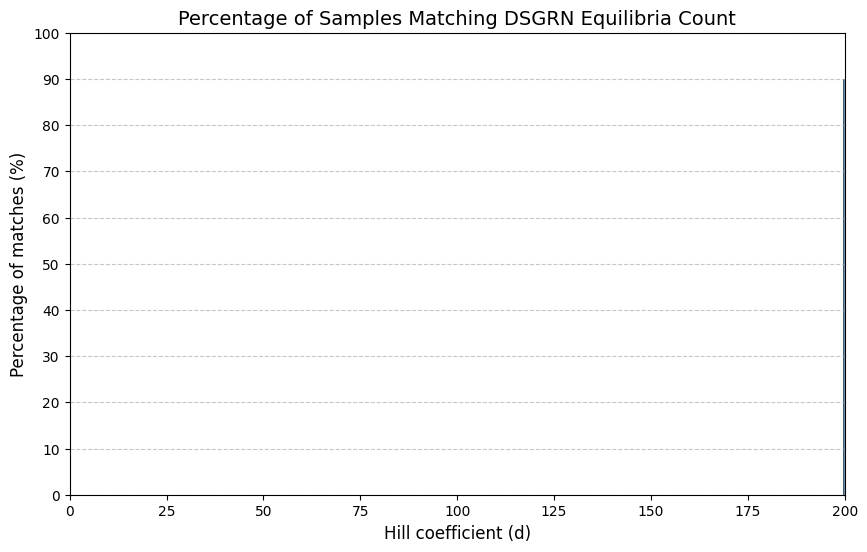


Summary:
Expected equilibria: 5
Best match percentage: 90.0% at d = 200
Worst match percentage: 90.0% at d = 200


In [9]:
# Let's do a few less samples lol 
# samples_1000 = samples[:1000]
# samples = samples[:1000]
samples_100 = samples[:100]
samples = samples_100

# Use your pre-generated samples with sample tracking
results, summary, optimal_d, sample_results = analyze_hill_coefficients(
    network, 
    parameter, 
    samples, 
    d_range
)

print(f"\nSummary:")
print(f"Expected equilibria: {summary['expected_equilibria']}")
print(f"Best match percentage: {summary['best_match']:.1f}% at d = {summary['best_match_d']}")
print(f"Worst match percentage: {summary['worst_match']:.1f}% at d = {summary['worst_match_d']}")

In [10]:
# Example: Check which samples matched at a specific d value
d = 200  # Adjust this value based on your d_range
print(f"\nAt d={d}:")
print(f"Matching samples: {sample_results[d]['matches']}")
print(f"Failed samples: {sample_results[d]['failures']}")


At d=200:
Matching samples: [0, 1, 2, 3, 4, 5, 6, 7, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 29, 30, 31, 32, 33, 34, 36, 37, 38, 39, 41, 42, 43, 44, 45, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 79, 80, 81, 82, 84, 85, 87, 88, 89, 91, 92, 93, 94, 95, 96, 97, 98, 99]
Failed samples: [8, 9, 28, 35, 40, 46, 78, 83, 86, 90]


In [11]:
# Example: Track a specific sample across all d values
sample_id = sample_results[d]['failures'][0]  # You can change this to track different samples
print(f"\nTracking sample {sample_id}:")
matching_d = [d for d in d_range if sample_id in sample_results[d]['matches']]
failing_d = [d for d in d_range if sample_id in sample_results[d]['failures']]
print(f"Matching d values: {matching_d}")
print(f"Failing d values: {failing_d}")


Tracking sample 8:
Matching d values: []
Failing d values: [200]


In [12]:
par_sample = samples[sample_id]
L, U, T = extract_parameter_matrices(par_sample, network)
plot_nullclines_interactive(L, U, T, d)

interactive(children=(FloatSlider(value=5.0, continuous_update=False, description='d:', max=200.0, min=1.0, st…

In [13]:
print(T)

[[1.84511259 1.84968863]
 [0.8534851  0.54985193]]
